In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

%matplotlib inline  

In [24]:
import os 
from glob import glob

INPUT_PATH = '../'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")

TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)

In [25]:
train_files = glob(os.path.join(TRAIN_DATA, "*.jpg"))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]

test_files = glob(os.path.join(TEST_DATA, "*.jpg"))
test_ids = [s[len(TEST_DATA)+1:-4] for s in test_files]

In [26]:
image_size = (864//2,576//2)

In [27]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [28]:
import cv2
from PIL import Image

def mean_shift(input_img):
    # Shape of original image
    originShape = input_img.shape
    # Converting image into array of dimension [nb of pixels in originImage, 3]
    # based on r g b intensities    
    flatImg=np.reshape(input_img, [-1, 3])


    # Estimate bandwidth for meanshift algorithm    
    bandwidth = estimate_bandwidth(flatImg, quantile=0.1, n_samples=50)    
    ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)

    # Performing meanshift on flatImg    
    ms.fit(flatImg)

    # (r,g,b) vectors corresponding to the different clusters after meanshift    
    labels=ms.labels_
    
    # Remaining colors after meanshift    
    cluster_centers = ms.cluster_centers_    

    # Finding and diplaying the number of clusters    
    labels_unique = np.unique(labels)    
    n_clusters_ = len(labels_unique)
    
    return np.reshape(labels, (*input_img.shape[:2], 1))


def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if True:
        img = cv2.resize(img, image_size)
        # Add salt-and-pepper noise to the image.
    return img/np.max(img)


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)
    if True:
#         img_pil = img_pil.resize((388, 388))
        img_pil = img_pil.resize(image_size)
    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

In [29]:
img = get_image_data(test_ids[0], 'Test')

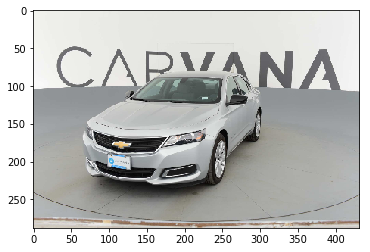

In [30]:
plt.imshow(img)

In [31]:
img.shape

(288, 432, 3)

In [ ]:
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
# from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import flip_axis, ImageDataGenerator

img_gen = ImageDataGenerator()

import tensorflow as tf
from scipy import ndimage, misc

In [ ]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return (numerator + 1) / (denominator + 1)

dependencies = {
    'dice_loss': dice_loss
}

# load model
model = load_model('unet_30_iter_binary_loss_432_288_deep.h5', custom_objects=dependencies)

In [ ]:
pred = model.predict(np.rot90(img).reshape(1, *img.shape[:2][::-1], 3))

In [ ]:
pred.shape

In [ ]:
# plt.imshow(np.around(pred[0], decimals=1))
pred_round = np.ndarray.round(pred[0])
plt.imshow(pred_round.reshape(432, 288))

In [ ]:
np.unique(pred_round)

In [ ]:
plt.imshow(cv2.resize(np.rot90(pred.reshape(432,288), -1), (1918, 1280) ))

In [ ]:
plt.imshow(np.rot90(pred[0].reshape(432,288), -1))

In [ ]:
plt.imshow(cv2.resize(np.rot90(pred[0].reshape(432,288), -1), (1918, 1280) ))

In [14]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
already_written = []

In [ ]:
def readfile(bs):
    X = np.empty((bs, *image_size, 3))
    for b in range(bs):
        img = get_image_data(test_ids[i*bs+b], 'Test')
        X[b] = np.rot90(img).reshape(1, *img.shape[:2][::-1], 3)
    return X

%timeit readfile(2)

In [ ]:
batch_size = 1

# for i in range(len(test_ids)//batch_size):
for i in range(1):
    X = np.empty((batch_size, *image_size, 3))
    for b in range(batch_size):
        img = get_image_data(test_ids[i*batch_size+b], 'Test')
        X[b] = np.rot90(img).reshape(1, *img.shape[:2][::-1], 3)
    pred = model.predict(X)

In [ ]:
%timeit model.predict(X)

In [ ]:
file1 = open("MyFile.txt","a")
batch = 32

for i in range(len(test_ids)):
    if i not in already_written:
        img = get_image_data(test_ids[i], 'Test')
        # the model was trained on a rotated image
        pred = model.predict(np.rot90(img).reshape(1, *img.shape[:2][::-1], 3))
    #     print(pred.shape)
        # realign and resize
        pred_realign = cv2.resize(np.rot90(pred.reshape(432,288), -1), (1918, 1280) )
        pred_round = np.ndarray.round(pred_realign)

        rle = str(test_ids[i]) + ", " + rle_encode(pred_round)
        file1.write("%s\n" % rle)
        already_written.append(i)
    if i%50 == 0:
        print(i)

file1.close()

In [ ]:
plt.imshow(pred_realign)#pred.reshape(432, 288))

In [ ]:
np.unique(pred_round)

In [ ]:
img = get_image_data(train_ids[10], 'Train_mask')

In [ ]:
rle_encode(img)

In [63]:
df = pd.read_csv('/home/usman/Downloads/MyFile.txt', names=["id", "rle"])

In [64]:
len(df)

100

In [65]:
df.iloc[92]['rle']

' 863924 5 865805 16 865840 8 867722 21 867759 6 869638 27 871387 2 871396 1 871553 35 873299 18 873467 41 875215 23 875381 50 877131 32 877246 11 877294 81 879048 39 879133 206 879340 25 880965 42 881047 240 882882 44 882963 246 884799 47 884879 262 886716 49 886795 277 887094 4 888633 51 888711 308 890550 53 890628 312 892467 56 892544 317 894384 404 896301 413 898219 416 900135 419 902032 8 902049 426 903944 473 905856 483 907771 488 909686 494 911599 511 913514 518 915427 525 917342 530 919256 537 921140 1 921162 551 923055 8 923073 559 924971 581 926888 584 928805 588 930722 591 932639 596 934557 598 936474 602 938392 604 940310 606 942227 608 944145 610 946063 613 947980 617 949898 618 951816 619 953734 620 955652 623 957569 627 959487 628 961405 631 963323 632 965240 634 967158 635 969076 636 970993 638 972911 639 974829 640 976746 642 978664 645 980580 649 982497 652 984414 654 986331 656 988247 663 990163 667 992080 670 993995 674 995910 677 997825 681 999741 683 1001658 685 1

In [66]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [67]:
dec = rle_decode(df.iloc[92]['rle'], shape=(1280, 1918))

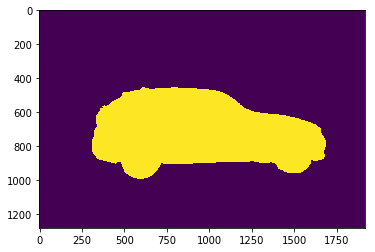

In [68]:
plt.imshow(dec)

In [74]:
df = pd.read_csv('submission.csv', names=['id','rle_mask'])

In [75]:
df_ids = pd.read_csv('test_ids.txt', names='img')

In [89]:
df['img'] = df_ids['i'] + '.jpg'

In [90]:
df[:20]

,id,rle_mask,img
0,0004d4463b50_01,610844 3 612742 31 614631 102 616543 113 6184...,0004d4463b50_01.jpg
1,0004d4463b50_01,610834 21 612739 54 614631 108 614744 30 6165...,0004d4463b50_02.jpg
2,0004d4463b50_01,610845 3 610862 3 612749 47 614647 91 614749 ...,0004d4463b50_03.jpg
3,0004d4463b50_01,612992 6 614664 72 614907 11 616577 81 616671...,0004d4463b50_04.jpg
4,0004d4463b50_01,614670 66 616582 75 618498 109 620413 116 622...,0004d4463b50_05.jpg
5,0004d4463b50_01,614677 51 616590 64 616670 21 618504 71 61857...,0004d4463b50_06.jpg
6,0004d4463b50_01,614675 49 614756 15 616588 60 616669 23 61850...,0004d4463b50_07.jpg
7,0004d4463b50_01,614676 48 616589 58 616672 12 618505 66 61858...,0004d4463b50_08.jpg
8,0004d4463b50_01,614673 46 616587 58 618500 66 618592 3 620413...,0004d4463b50_09.jpg
9,0004d4463b50_01,614672 38 616581 54 618497 59 620409 68 62231...,0004d4463b50_10.jpg


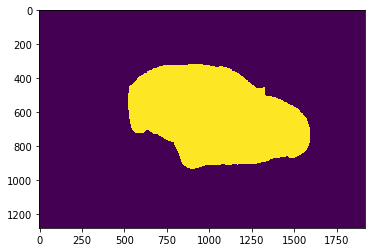

In [91]:
dec = rle_decode(df.iloc[15]['rle_mask'], shape=(1280, 1918))
plt.imshow(dec)

In [93]:
df[['img', 'rle_mask']].to_csv('submission_1.csv', index=False)

In [92]:
len(df['img'].unique())

100064